In [122]:
import glob
import xarray as xr
import pandas as pd
import json

import warnings
warnings.filterwarnings("ignore")

In [123]:
# !pip install jinja2
# !python -m pip install "dask[diagnostics]"
# !pip install netcdf4
# !pip install matplotlib

In [202]:
# Get the list of processed files
input_files = sorted(glob.glob('input/data/*.trf'))
output_files = sorted(glob.glob('output/netCDF/*.nc'))

In [211]:
print('Number of input files:', len(input_files))
print('Number of output files:', len(output_files))

Number of input files: 2039
Number of output files: 1662


In [217]:
input_timestamp_pattern = 'input/data/RD-%Y%m%d-%H%M%S.trf'
output_timestamp_pattern = 'output/netCDF/att01rd80CA.b1.%Y%m%d.%H%M%S.nc'

# First input file stamp
first_input_stamp = pd.to_datetime(input_files[0], format=input_timestamp_pattern)
last_input_stamp = pd.to_datetime(input_files[-1], format=input_timestamp_pattern)
print('First input file:', first_input_stamp, 'Last input file:', last_input_stamp)

# First output file stamp
first_output_stamp = pd.to_datetime(output_files[0], format=output_timestamp_pattern)
last_output_stamp = pd.to_datetime(output_files[-1], format=output_timestamp_pattern)
print('First output file:', first_output_stamp, 'Last output file:', last_output_stamp)

First input file: 2020-03-03 13:19:00 Last input file: 2024-09-18 20:36:00
First output file: 2020-03-03 00:00:00 Last output file: 2024-09-19 00:00:00


#### 1 - Check if algorithm create correct number of netCF files

In [234]:
# Check if outputfiles are missing from the list
full_output_timestamps = pd.date_range(start=first_output_stamp, end=last_output_stamp, freq='1D')
if len(output_files) != len(full_output_timestamps):
    print('Error - Missing output files:', len(full_output_timestamps) - len(output_files))
    missing_output_files = full_output_timestamps[~full_output_timestamps.isin(pd.to_datetime(output_files, format=output_timestamp_pattern))]
    print('Error - Missing output files:', missing_output_files)
else:
    print('OK - All output files are present, with number:', len(output_files))

OK - All output files are present, with number: 1662


##### 2 - Check if algorithm create correct time series into netCF files

In [232]:
# Read all the output files
ouput_ds = xr.open_mfdataset(output_files, combine='nested', concat_dim='time')

In [256]:
# Check if first time stamp is correct
if first_output_stamp.date() == pd.to_datetime(ouput_ds.time[0].values).date():
    print('OK - First output file time stamp is correct')
else:
    print('Error - First output file time stamp is incorrect')
# Check if last time stamp is correct
if last_output_stamp.date() == pd.to_datetime(ouput_ds.time[-1].values).date():
    print('OK - Last output file time stamp is correct')
else:
    print('Error - Last output file time stamp is incorrect')
# Check if the number of time stamps is correct
if len(full_output_timestamps) == len(ouput_ds.time.resample(time='1D').count()):
    print('OK - All output file time stamps are correct')
else:
    print('Error - Some output file time stamps are incorrect')

OK - First output file time stamp is correct
OK - Last output file time stamp is correct
OK - All output file time stamps are correct


##### 3 - Check if algorithm create correct time series between two input and output netCF files

In [257]:
from utils.disdrometer_utils import *

with open('input/support/variables_info.json', "r") as xfile:
    variables_info_file = xfile.read()
variables_info = json.loads(variables_info_file)
columns = variables_info['Columns']

# Open input files
input_df = read_files_rd80(input_files, columns=columns)

In [261]:
first_input_stamp = input_df.index.min()
last_input_stamp = input_df.index.max()
print('First input file:', first_input_stamp, 'Last input file:', last_input_stamp)

First input file: 2020-03-03 13:19:00 Last input file: 2024-09-19 20:35:00


In [ ]:


# with open('input/support/netCDF_info_ARM.json', "r") as xfile:
#     netCDF_info_file = xfile.read()
# netCDF_info = json.loads(netCDF_info_file)

In [ ]:
from utils.netcdf_utils import *

In [48]:
len(input_files), len(output_files)

(2039, 1264)

In [21]:
# Read all files
input_df = read_files_rd80(input_files, columns=columns)
input_ds = xr.open_mfdataset(output_files, combine='nested', concat_dim='time')

In [42]:
# Groupby index where the index i need is all values of day
day_groups = input_df.groupby(input_df.index.date)
for export_date, all_data in day_groups:
    # Full time
    full_time = pd.date_range(start=export_date, end=export_date + pd.Timedelta(days=1), freq='1 min')[:-1]
    all_data = all_data.reindex(full_time, fill_value=np.nan)
    # Validate Rain Intensity
    rr_df = all_data['RI'].values
    rr_ds = input_ds['rain_rate'].sel(time=export_date.strftime('%Y-%m-%d')).compute().data

    # Cast export_date to datetime
    export_date = pd.to_datetime(export_date)

    export_date, day_data, flag = get_day_data(all_data, export_date, variables_info)

    (dimension_nc,filled_variables) = extract_variables(day_data,variables_info,netCDF_info)



    # Fill the missing values into all_data where interval is 1 minute
    

    break

Extracting variables from the data


In [44]:
filled_variables

{'lat': -2.1815896,
 'lon': -59.0218639,
 'alt': 59.0,
 'base_time': 1583193600.0,
 'time_offset': array([0.000e+00, 6.000e+01, 1.200e+02, ..., 8.622e+04, 8.628e+04,
        8.634e+04]),
 'time': array([0.000e+00, 6.000e+01, 1.200e+02, ..., 8.622e+04, 8.628e+04,
        8.634e+04]),
 'drop_avg_class': array([0.359, 0.455, 0.551, 0.656, 0.771, 0.913, 1.116, 1.331, 1.506,
        1.665, 1.912, 2.259, 2.584, 2.869, 3.198, 3.544, 3.916, 4.35 ,
        4.859, 5.373]),
 'fall_velocity': array([1.435, 1.862, 2.267, 2.692, 3.154, 3.717, 4.382, 4.986, 5.423,
        5.793, 6.315, 7.009, 7.546, 7.903, 8.258, 8.556, 8.784, 8.965,
        9.076, 9.137]),
 'delta_diam': array([0.092, 0.1  , 0.091, 0.119, 0.112, 0.172, 0.233, 0.197, 0.153,
        0.166, 0.329, 0.364, 0.286, 0.284, 0.374, 0.319, 0.423, 0.446,
        0.572, 0.455]),
 'num_drop': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [

In [31]:
rr_ds.shape

(1440,)

In [98]:
rr_df.shape

(641,)

<Axes: xlabel='Date_Time'>

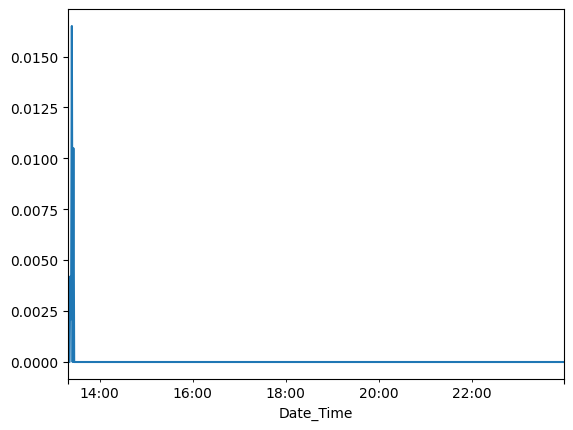

In [45]:
all_data['RI'].plot()

In [19]:
time_interval = input_df['Interval'].to_numpy()
num_drop = input_df[variables_info["drop_col"]].to_numpy()

In [18]:
get_ri_rd80(input_df, num_drop)

<function utils.disdrometer_utils.get_ri_rd80(drop_sizes, interval, drop_diam, sensor_area)>

In [17]:
input_ds

<xarray.Dataset> Size: 728MB
Dimensions:                       (time: 1820160, drop_avg_class: 20)
Coordinates:
  * time                          (time) datetime64[ns] 15MB 2020-03-03 ... 2...
  * drop_avg_class                (drop_avg_class) float32 80B 0.359 ... 5.373
Data variables: (12/19)
    base_time                     (time) datetime64[ns] 15MB 2020-03-03 ... 2...
    time_offset                   (time) datetime64[ns] 15MB dask.array<chunksize=(1440,), meta=np.ndarray>
    lat                           (time) float32 7MB -2.182 -2.182 ... -2.182
    lon                           (time) float32 7MB -59.02 -59.02 ... -59.02
    alt                           (time) float32 7MB 59.0 59.0 ... 59.0 59.0
    fall_velocity                 (time, drop_avg_class) float32 146MB dask.array<chunksize=(1440, 20), meta=np.ndarray>
    ...                            ...
    rain_rate                     (time) float32 7MB dask.array<chunksize=(1440,), meta=np.ndarray>
    radar_reflectivity            (time) float32 7MB dask.array<chunksize=(1440,), meta=np.ndarray>
    liq_water                     (time) float32 7MB dask.array<chunksize=(1440,), meta=np.ndarray>
    energy_flux                   (time) float32 7MB dask.array<chunksize=(1440,), meta=np.ndarray>
    slope_parameter               (time) float32 7MB dask.array<chunksize=(1440,), meta=np.ndarray>
    distribution_intercept        (time) float32 7MB dask.array<chunksize=(1440,), meta=np.ndarray>
Attributes: (12/18)
    command_line:                JOSS_gen_netCDF.py -s
    process_version:             N/A yet
    dod_version:                 N/A yet
    Conventions:                 N/A yet
    data_level:                  b1
    platform_id:                 rd80
    ...                          ...
    doi:                         N/A yet
    datastream:                  att01rd80CA.b1
    averaging_interval:          None
    serial_number:               2102502
    calib_date:                  2021-08-06
    history:                     N/A yet